In [1]:
# ruff: noqa: F401, E402
import math
import sys
from bisect import bisect_left, bisect_right
from collections import Counter, deque
from functools import cmp_to_key, lru_cache, reduce
from heapq import heapify, heappop, heappush, heappushpop, nsmallest
from importlib import reload
from itertools import (
    accumulate,
    chain,
    combinations,
    islice,
    pairwise,
    permutations,
    product,
    starmap,
    tee,
)
from math import comb, factorial, log, sqrt
from operator import add, and_, contains, indexOf, itemgetter, neg, or_, xor
from pprint import pprint
from typing import Callable, Iterable, List, Tuple

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

import arrays
import graphs
import lists
import mathematics
import matrix
import parsing
import search
import sequences
import sets
import strings
import trees

for m in (
    arrays,
    graphs,
    lists,
    mathematics,
    matrix,
    parsing,
    search,
    sequences,
    sets,
    strings,
    trees,
):
    reload(m)


from parsing import format_binop_expression, parse_binop_expression
from sequences import find_if
from strings import StringView, splint

print()


In [145]:
def articulation_points(adj: List[List[int]]) -> List[int]:
    "Return the articulation points for a graph defined by the `adj` list."
    # This uses single pass Tarjan's Algorithm.
    vt = [0] * len(adj)  # visited time for each node in DFS-tree order
    ct = vt[:]  # circle time for the parent/root of the whole circle
    o = []

    def dfs(p, n, t):
        vt[n] = ct[n] = t
        art = kids = 0
        for c in adj[n]:
            if not vt[c]:  # If the child node was not visited...
                dfs(n, c, t + 1)
                kids += 1
                art |= ct[c] >= t
                ct[n] = min(ct[n], ct[c])
            elif c != p:
                ct[n] = min(ct[n], vt[c])
        if art if p != -1 else kids > 1:
            o.append(n)

    # Start search from the first node (== 0).
    dfs(-1, 0, 1)
    return sorted(o), vt, ct


In [294]:
def articulation_points(adj: List[List[int]]) -> List[int]:
    "Return graph articulation points."
    # Expects a strongly connected graph. `adj` contains symmetric edges.
    vt = [0] * len(adj)  # visited time for each node in DFS-tree order
    ct = vt[:]  # uplink min connection time
    t = 0  # Tarjan's DFS node index
    s1 = [(-1, 0)]  # root node with -1 as parent
    s2 = []  # second stack for non root child nodes

    root_kids = -1  # used for the root only
    while s1:
        p, n = s1.pop()
        if vt[n]:  # skip visited
            continue
        vt[n] = ct[n] = t = t + 1  # set the times
        if p > 0:  # non-root children
            s2.append((p, n))
        else:
            root_kids += 1
        for c in adj[n]:
            if not vt[c]:
                s1.append((n, c))

    # Using a set as a parent node may be an AP
    # for multiple other nodes.
    # Root is an articulate point
    # if it had mode than one child node.
    aps = set([0] if root_kids > 1 else [])
    # process non root child nodes
    while s2:
        p, n = s2.pop()
        # Use min vt for any tree- or back-edges (except parent)
        ct[n] = reduce(min, (vt[c] for c in adj[n] if c != p), ct[n])
        # Lower parent `ct`
        ct[p] = min(ct[p], ct[n])
        # If this node `ct` is higher than parent `vt`,
        # then we were unable to connect to parent component
        # using any other edge or node. Parent must be an AP.
        if vt[p] <= ct[n]:
            aps.add(p)
    return sorted(aps)


[1, 4]
[1, 2, 5, 4, 3]
[1, 2, 3, 3, 3]


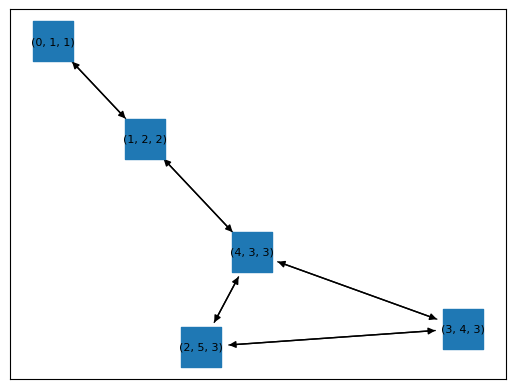

In [295]:
adj = [[1], [0, 4], [4, 3], [4, 2], [1, 2, 3]]
aps, vt, ct = articulation_points(adj)
print(aps)
print(vt)
print(ct)
labels = dict(enumerate(zip(range(len(adj)), vt, ct)))
g = nx.DiGraph(dict(enumerate(adj)))
nx.draw_networkx(g, labels=labels, node_shape="s", node_size=800, font_size=8)


[0, 3, 4, 5]
[1, 4, 7, 3, 2, 6, 5]
[1, 4, 7, 3, 2, 6, 5]


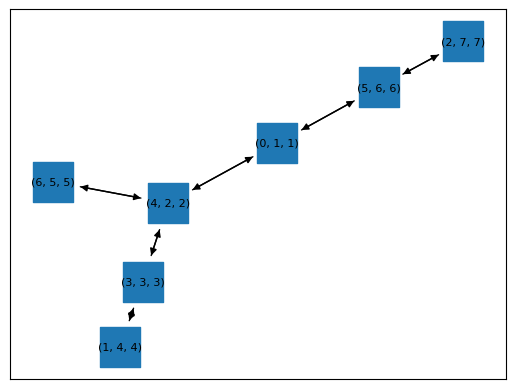

In [292]:
adj = [[5, 4], [3], [5], [1, 4], [6, 0, 3], [0, 2], [4]]
aps, vt, ct = articulation_points(adj)
print(aps)
print(vt)
print(ct)
labels = dict(enumerate(zip(range(len(adj)), vt, ct)))
g = nx.DiGraph(dict(enumerate(adj)))
nx.draw_networkx(g, labels=labels, node_shape="s", node_size=800, font_size=8)


[6]
[1, 9, 5, 4, 3, 8, 6, 7, 2]
[1, 1, 1, 1, 1, 1, 1, 7, 1]


[1, 1, 1, 1, 1, 1, 1, 1]

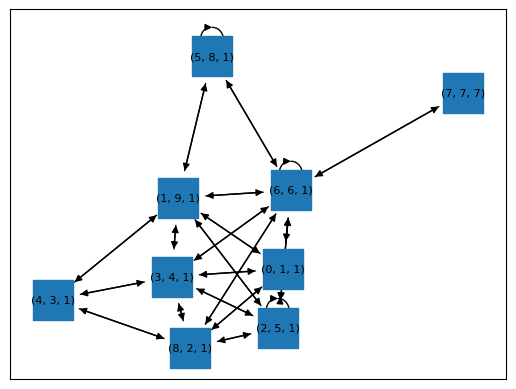

In [291]:
adj = [
    [2, 2, 1, 3, 6, 8],
    [3, 4, 2, 5, 5, 3, 0, 6],
    [1, 2, 2, 0, 6, 6, 2, 2, 0, 6, 8, 3],
    [4, 1, 6, 8, 1, 0, 4, 2],
    [3, 1, 8, 3],
    [5, 5, 1, 6, 1, 6],
    [6, 6, 2, 2, 3, 6, 6, 5, 2, 8, 1, 5, 0, 7],
    [6],
    [3, 2, 6, 4, 0],
]
# [list(set(a)) for a in adj]

# adj = [
#     [2, 1, 3, 6, 8],
#     [2, 3, 4, 5, 0, 6],
#     [1, 2, 3, 0, 6, 8],
#     [1, 2, 4, 6, 0, 8],
#     [8, 1, 3],
#     [1, 5, 6],
#     [1, 2, 3, 5, 6, 0, 7, 8],
#     [6],
#     [2, 3, 4, 6, 0],
# ]
aps, vt, ct = articulation_points(adj)
print(aps)
print(vt)
print(ct)
labels = dict(enumerate(zip(range(len(adj)), vt, ct)))
g = nx.DiGraph(dict(enumerate(adj)))
nx.draw_networkx(g, labels=labels, node_shape="s", node_size=800, font_size=8)
[ct[c] for c in adj[1]]


[0, 5, 8]
[1, 8, 3, 5, 7, 9, 2, 10, 6, 4]
[1, 8, 1, 1, 7, 9, 1, 10, 1, 1]


[1]

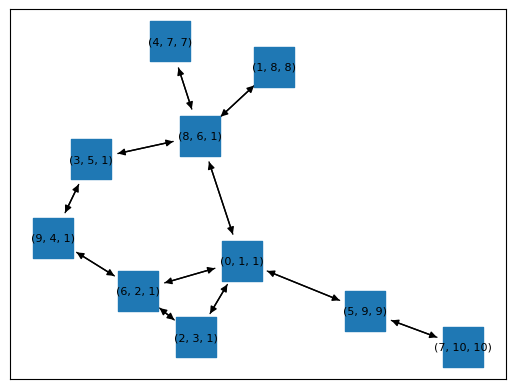

In [290]:
# adj = [[5, 2, 6, 8], [8], [0, 6], [9, 8, 8, 9], [8], [7, 0], [0, 2, 9], [5], [1, 3, 3, 0, 4], [3, 3, 6]]

adj = [
    [8, 2, 5, 6],
    [8],
    [0, 6],
    [8, 9],
    [8],
    [0, 7],
    [0, 9, 2],
    [5],
    [0, 1, 3, 4],
    [3, 6],
]

aps, vt, ct = articulation_points(adj)
print(aps)
print(vt)
print(ct)
labels = dict(enumerate(zip(range(len(adj)), vt, ct)))
g = nx.DiGraph(dict(enumerate(adj)))
nx.draw_networkx(g, labels=labels, node_shape="s", node_size=800, font_size=8)
[ct[c] for c in adj[1]]


[6]
[1, 6, 9, 8, 7, 5, 3, 4, 2]
[1, 1, 1, 1, 1, 1, 1, 4, 1]


[1, 1, 1, 1, 1, 1]

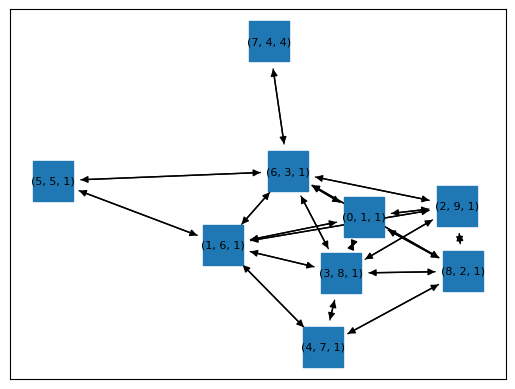

In [289]:
# adj = [[2, 2, 1, 3, 6, 8], [3, 4, 2, 5, 5, 3, 0, 6], [1, 2, 2, 0, 6, 6, 2, 2, 0, 6, 8, 3], [4, 1, 6, 8, 1, 0, 4, 2], [3, 1, 8, 3], [5, 5, 1, 6, 1, 6], [6, 6, 2, 2, 3, 6, 6, 5, 2, 8, 1, 5, 0, 7], [6], [3, 2, 6, 4, 0]]

adj = [
    [1, 2, 3, 6, 8],
    [0, 2, 3, 4, 5, 6],
    [0, 1, 3, 6, 8],
    [0, 1, 2, 4, 6, 8],
    [1, 3, 8],
    [1, 6],
    [0, 1, 2, 3, 5, 7, 8],
    [6],
    [0, 2, 3, 4, 6],
]

aps, vt, ct = articulation_points(adj)
print(aps)
print(vt)
print(ct)
labels = dict(enumerate(zip(range(len(adj)), vt, ct)))
g = nx.DiGraph(dict(enumerate(adj)))
nx.draw_networkx(g, labels=labels, node_shape="s", node_size=800, font_size=8)
[ct[c] for c in adj[1]]


In [156]:
aps, vt, ct = articulation_points(adj)
print(aps)
print(vt)
print(ct)
[ct[c] for c in adj[1]]


[6]
[1, 2, 3, 4, 5, 8, 7, 8, 6]
[1, 1, 1, 1, 1, 2, 1, 8, 1]


[1, 1, 1, 1, 2, 1]

([1, 2], [1, 2, 3, 4, 5, 6, 4, 5], [1, 2, 2, 2, 2, 2, 3, 3])

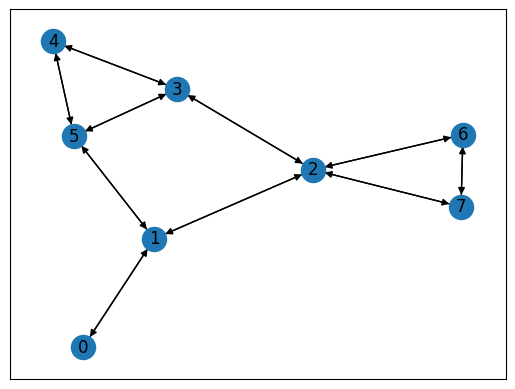

In [146]:
adj = [
    [1],
    [0, 2, 5],
    [1, 3, 6, 7],
    [2, 4, 5],
    [3, 5],
    [4, 1, 3],
    [2, 7],
    [6, 2],
]
g = nx.DiGraph(dict(enumerate(adj)))
nx.draw_networkx(g)
articulation_points(adj)


[1, 2]

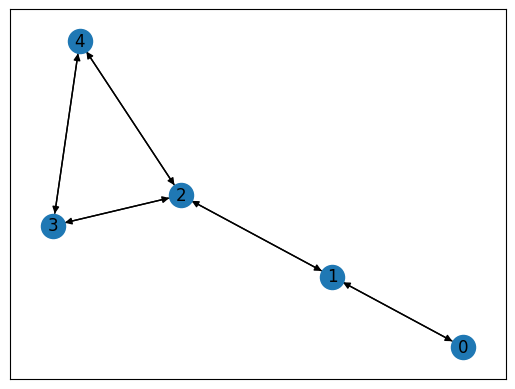

In [86]:
adj = [[1], [2, 0], [1, 3, 4], [2, 4], [2, 3]]
g = nx.DiGraph(dict(enumerate(adj)))
nx.draw_networkx(g)
articulation_points(adj)


[5, 6]

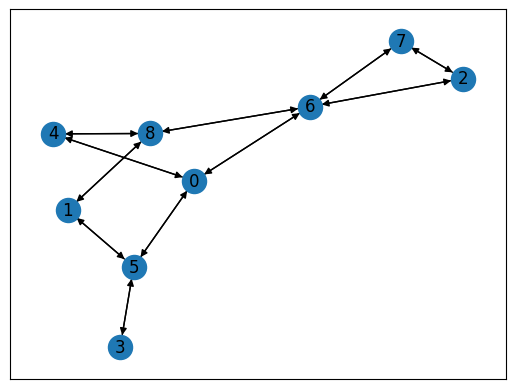

In [87]:
adj = [
    [6, 5, 4],
    [8, 5],
    [6, 7],
    [5],
    [8, 0],
    [0, 3, 1],
    [0, 8, 7, 2],
    [6, 2],
    [6, 4, 1],
]
g = nx.DiGraph(dict(enumerate(adj)))
nx.draw_networkx(g)
articulation_points(adj)


[0]

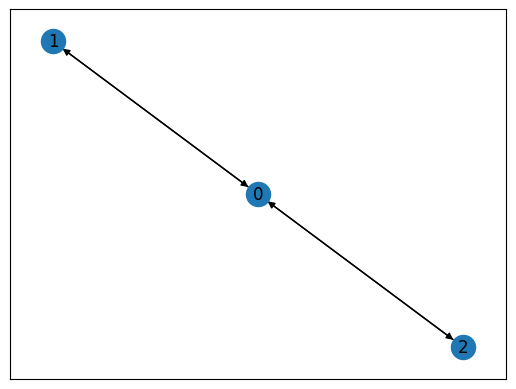

In [88]:
adj = [[1, 2], [0], [0]]
g = nx.DiGraph(dict(enumerate(adj)))
nx.draw_networkx(g)
articulation_points(adj)


[2]

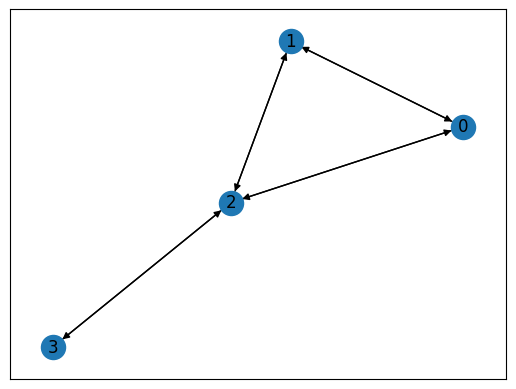

In [89]:
adj = [[1, 2], [0, 2], [0, 1, 3], [2]]
g = nx.DiGraph(dict(enumerate(adj)))
nx.draw_networkx(g)
articulation_points(adj)
